In [6]:
import pandas as pd
import os
import glob

#### -------- from main folders ---------

In [ ]:
brent_path = 'I:\Crude Oil Department\Analytics\wq\DG_Data\Brent'
DFL_path = 'I:\Crude Oil Department\Analytics\wq\DG_Data\DFL'
WTI_path = 'I:\Crude Oil Department\Analytics\wq\DG_Data\WTI'
WTIBrent_path = 'I:\Crude Oil Department\Analytics\wq\DG_Data\WTIBrent'
BrentDubai_path = 'I:\Crude Oil Department\Analytics\wq\DG_Data\BrentDubai'
cfd_path = 'I:\\Crude Oil Department\\Analytics\\wq\\DG_Data\\NS Window'
freight_path = 'I:\\Crude Oil Department\\Analytics\\wq\\DG_Data\\DirtyFreight'

In [ ]:
path_list = [brent_path,DFL_path,WTI_path,WTIBrent_path, BrentDubai_path,cfd_path,freight_path]

In [ ]:
list_series = [glob.glob(os.path.join(folder, "*.csv")) for folder in path_list]
flat_path_list = [item for sublist in list_series for item in sublist]

In [ ]:
def csv_transposed(paths):
    grid_list = []
    for path in paths:
        df = pd.read_csv(path)
        df = df.melt(id_vars=df.columns[0])
        df['path'] = path
        df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
        grid_list.append(df)
    grid_values =  pd.concat(grid_list)
#     grid_values.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    return grid_values

In [ ]:
def path_to_filename(df):
    path_list = df['path'].str.split(r'\\').to_list()
    df['filename'] = [path[-1] for path in path_list]
    df['filename'] = df['filename'].str.replace('.csv','')
    return df

In [ ]:
def path_to_foldername(df):
    path_list = df['path'].str.split(r'\\').to_list()
    df['filename'] = [path[-2] for path in path_list]
    return df

In [ ]:
crude = path_to_foldername(csv_transposed(flat_path_list))

#### -------------- european margin prices ------------------

In [ ]:
margin_folder = 'I:\Crude Oil Department\Analytics\wq\DG_Data\European Margin'

In [ ]:
exception_file = 'I:\\Crude Oil Department\\Analytics\\wq\\DG_Data\\European Margin\\TTF_EXP.csv'

In [ ]:
def nwe_get_csv_transposed(folder):
    paths = glob.glob(os.path.join(folder, "*.csv"))
    grid_list = []
    for path in paths:
        if path == exception_file:
            print('excluding:{}'.format(path))
        else:
            df = pd.read_csv(path)
            df = df.melt(id_vars=df.columns[0])
            df['path'] = path
            df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
            grid_list.append(df)
    grid_values =  pd.concat(grid_list)
#     grid_values.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    return grid_values

In [ ]:
euro_margins = path_to_filename(nwe_get_csv_transposed(margin_folder))

#### -------------- adding curve models ------------------

In [ ]:
mapping1 = pd.read_excel('I:\Crude Oil Department\Analytics\wq\DG.xlsm', sheet_name='Model')
mapping2 = pd.read_excel('I:\Analysis Department\Crude\price_data\DG - Crude Daily Brief.xlsm', sheet_name='Model')
mapping = pd.concat([mapping1,mapping2])

In [ ]:
crude_mapped = crude.merge(mapping, how='left', left_on='variable', right_on='Name')

In [ ]:
margin_mapped = euro_margins.merge(mapping, how='left', left_on=['variable','filename'], right_on=['Name','FileName'])

In [ ]:
nwe_raw_msk = margin_mapped.filename.str.contains('NWERaw')
med_raw_msk = margin_mapped.filename.str.contains('MedRaw')
sg_raw_msk = margin_mapped.filename.str.contains('SGRaw')
nwe_pricing_msk = margin_mapped.filename.str.contains('NWEPricing')
med_pricing_msk = margin_mapped.filename.str.contains('MedPricing')
sg_pricing_msk = margin_mapped.filename.str.contains('SGPricing')

In [ ]:
def get_model_dict(df, msk):
    df = df.loc[msk,['variable', 'Model']].drop_duplicates(keep='first')
    return df

In [ ]:
nwe_map = get_model_dict(margin_mapped, nwe_pricing_msk)
med_map = get_model_dict(margin_mapped, med_pricing_msk)
sg_map = get_model_dict(margin_mapped, sg_pricing_msk)

In [ ]:
margin_mapped.loc[nwe_raw_msk,'Model'] = margin_mapped.loc[nwe_raw_msk,'variable'].map(nwe_map.set_index('variable')['Model'])
margin_mapped.loc[med_raw_msk,'Model'] = margin_mapped.loc[med_raw_msk,'variable'].map(med_map.set_index('variable')['Model'])
margin_mapped.loc[sg_raw_msk,'Model'] = margin_mapped.loc[sg_raw_msk,'variable'].map(sg_map.set_index('variable')['Model'])

In [ ]:
NumSeries = pd.concat([crude_mapped, margin_mapped])
NumSeries.drop(columns=['path', 'Type','Name', 'FileName', 'RelatedProject', 'SubProject', 'LastCurveDate', 'Path'], inplace=True)

In [ ]:
NumSeries.to_csv('test.csv', index=False)

In [13]:
references = pd.read_excel('I:\\Crude Oil Department\\Analytics\\wq\\DG.xlsm', sheet_name='Model')

In [14]:
series_models = references[references.Type=='NumericSeries']['Model'].to_list()

In [15]:
from_date = datetime.date(2015, 1, 1)
to_date = datetime.date.today()

In [18]:
series_list = []
for model in series_models:
    df = dg.get_time_series(model, from_date, to_date)
    df['model'] = model
    series_list.append(df)

In [19]:
series_df = pd.concat(series_list)

In [20]:
series_df

PRICE                                              model
2015-01-01     NaN          model://ICETTFREL/EU.NG.TTF.ICE.FUT.B.M01
2015-01-02  20.448          model://ICETTFREL/EU.NG.TTF.ICE.FUT.B.M01
2015-01-05  20.145          model://ICETTFREL/EU.NG.TTF.ICE.FUT.B.M01
2015-01-06  19.538          model://ICETTFREL/EU.NG.TTF.ICE.FUT.B.M01
2015-01-07  19.594          model://ICETTFREL/EU.NG.TTF.ICE.FUT.B.M01
...            ...                                                ...
2021-12-31  -0.950  model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W08
2022-01-03     NaN  model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W08
2022-01-04  -0.470  model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W08
2022-01-05  -0.400  model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W08
2022-01-06     NaN  model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W08

[140987 rows x 2 columns]

In [44]:
brent_2022m1 = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.2022M01'
brent_abs = dg.get_time_series(brent_2022m1, datetime.date(2020,1,1), datetime.date(2021,10,1))

<AxesSubplot:ylabel='Frequency'>

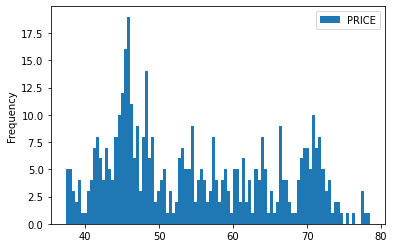

In [45]:
brent_abs.plot(kind='hist', bins=100)

In [42]:
brent_M7 = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M07'
brent_M7 = dg.get_time_series(brent_M7, datetime.date(2018,1,1), datetime.date(2021,10,1))

<AxesSubplot:ylabel='Frequency'>

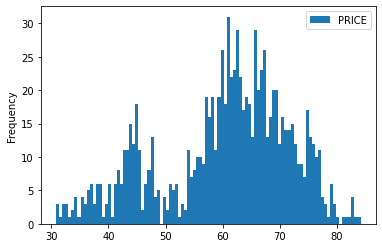

In [43]:
brent_M7.plot(kind='hist', bins=100)

In [6]:
brent_curve = dg.get_curve('model://PI_OIL_CRU_ICE/PI.BRENT.ICE.USD.BBL.C')

In [48]:
wti_curve = dg.get_curve('model://CMENYMCL_REL/US.NYMEX.CME.ELECTRONIC.FUT.CL.M01')

ERROR: curve not found model://CMENYMCL_REL/US.NYMEX.CME.ELECTRONIC.FUT.CL.M01


In [7]:
brent_curve = dg.get_curve('model://PI_OIL_CRU_ICE/PI.BRENT.ICE.USD.BBL.C')

In [8]:
brent_curve

TENOR                                             SOURCE   PRICE
2022-08-01   M01  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...  106.62
2022-09-01   M02  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...  102.13
2022-10-03   M03  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   99.24
2022-11-01   M04  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   97.06
2022-12-01   M05  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   95.26
...          ...                                                ...     ...
2028-10-02   M75  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   74.41
2028-11-01   M76  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   74.36
2028-12-01   M77  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   74.31
2029-01-02   M78  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   74.26
2029-02-01   M79  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...   74.21

[79 rows x 3 columns]

In [103]:
brent_curve[brent_curve['TENOR']=='M01']

TENOR                                             SOURCE   PRICE
2022-08-01   M01  model://ICE_BRENT_1630_REL/EU.OIL.NSEA.ICE.BRE...  105.57

In [61]:
def brent_analysis(month_num):
    brent_m = f'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M{month_num}'
    brent_m = dg.get_time_series(brent_m, datetime.date(2020,1,1), datetime.date(2021,10,1))
    return brent_M7.plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

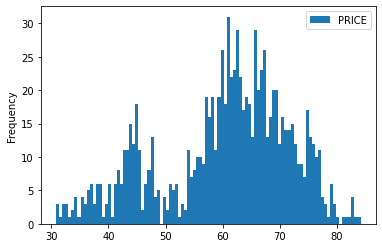

In [63]:
brent_analysis(24)

In [53]:
brent_M1 = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M01'
# brent_M1 = dg.get_time_series(brent_M1, datetime.date(1980,1,1), datetime.date.today())

In [7]:
brent_M2 = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M02'
brent_M2 = dg.get_time_series(brent_M2, datetime.date(1980,1,1), datetime.date.today())

In [8]:
spread = brent_M1-brent_M2

<AxesSubplot:title={'center':'brent m1-m2 spread'}>

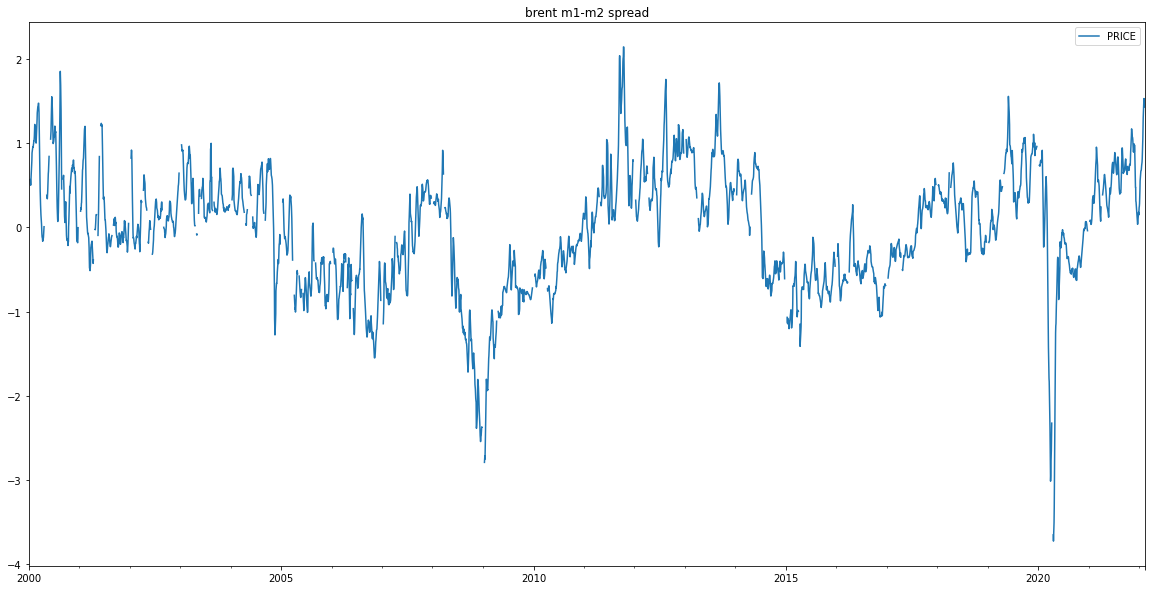

In [18]:
spread['2000-01-01':].rolling(7).mean().plot(kind='line', figsize=(20,10), title='brent m1-m2 spread')

In [25]:
urals_dg = 'model://PI_OIL_CRU_NSEA/PI.URALS.CIFRDAM.USD.BBL.C'
urals_c = dg.get_curve(urals_dg)

In [26]:
urals_dg_m1 = 'model://PI_OIL_CRU_NSEA/PI.URALS.CIFRDAM.USD.BBL.C/CURVE/M01/FINAL'
urals_ts = dg.get_time_series(urals_dg_m1, datetime.date(2022,1,1), datetime.date.today())

In [12]:
urals_diff_dg = 'model://PLATTS_RI/PLATTS.CRUDE.RI.AAGXJ00/MID/ALL'
urals_diff_ts = dg.get_time_series(urals_diff_dg, datetime.date(2002,1,1), datetime.date.today())

<AxesSubplot:title={'center':'Urals diff to DTD'}>

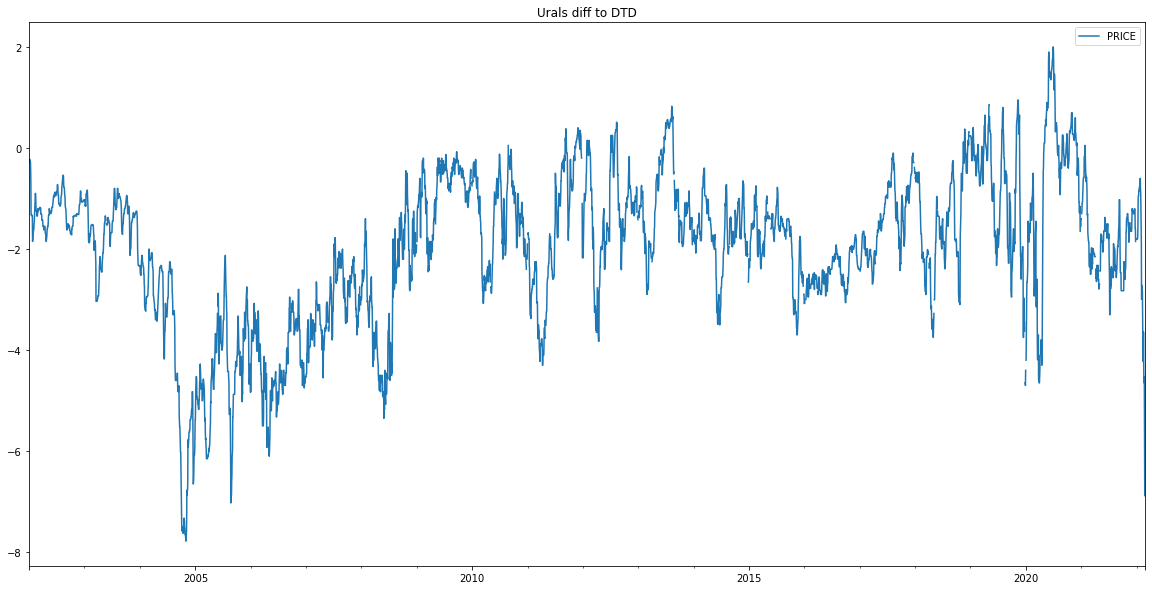

In [13]:
urals_diff_ts.plot(kind='line', figsize=(20,10), title=('Urals diff to DTD'))

In [6]:
cfd_w1_dg = 'model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W01'
cfd_w1 = dg.get_time_series(cfd_w1_dg, datetime.date(1980,1,1), datetime.date.today())

<AxesSubplot:title={'center':'cfd_w1'}>

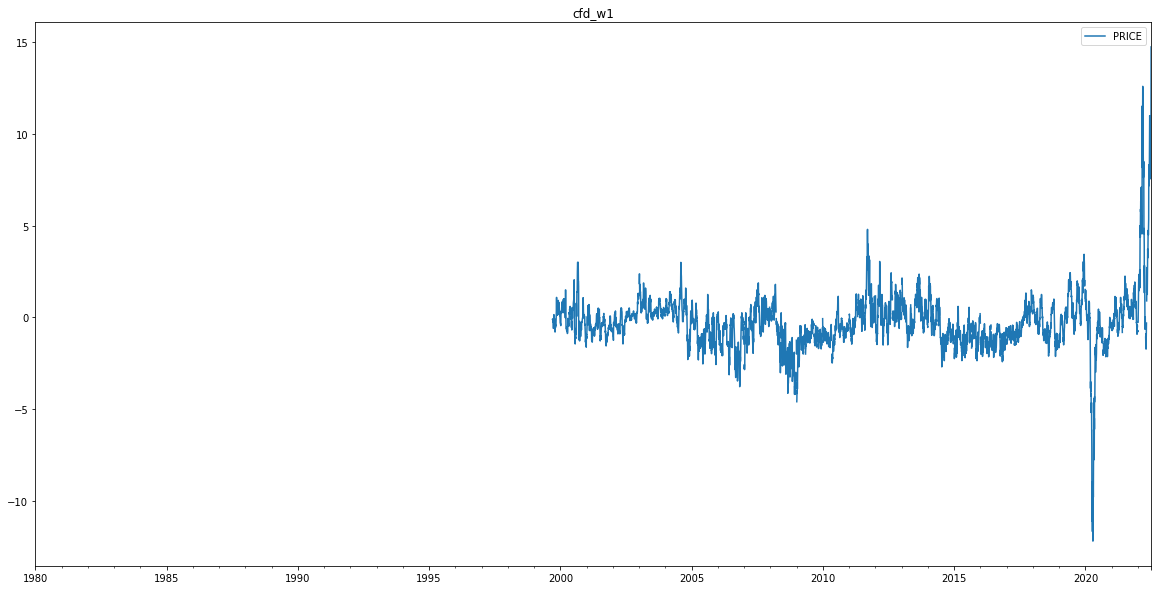

In [7]:
cfd_w1.plot(kind='line', figsize=(20,10), title=('cfd_w1'))

In [14]:
eko_dg = 'model://PLATTS_RI/PLATTS.CRUDE.RI.AAGWZ00/MID/ALL'

<AxesSubplot:title={'center':'cfd_w1'}>

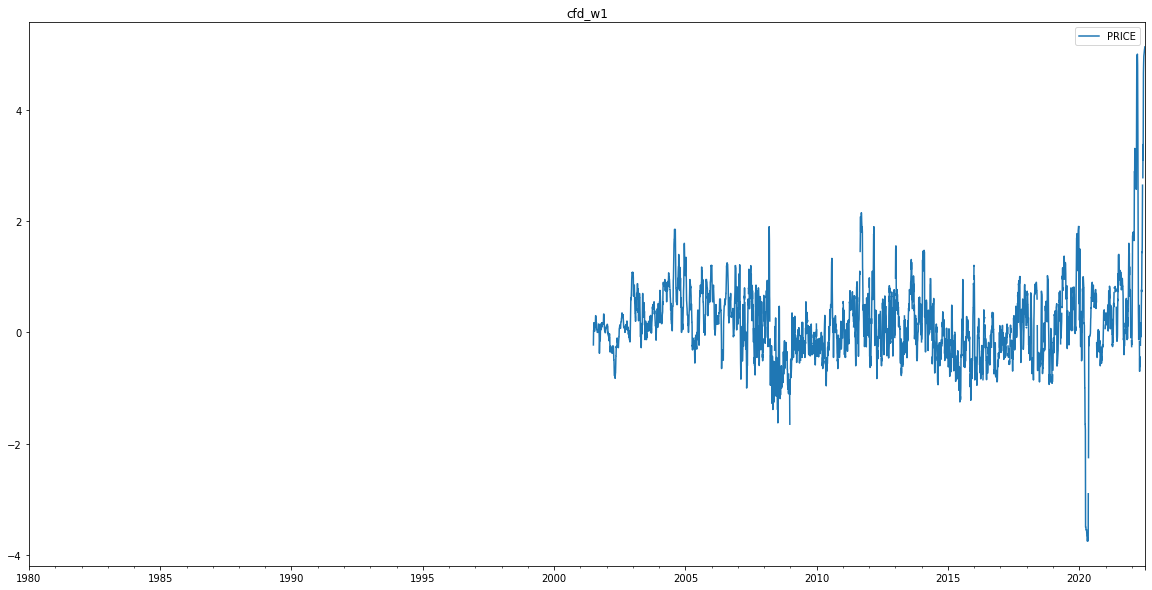

In [10]:
diff.plot(kind='line', figsize=(20,10), title=('cfd_w1'))

In [50]:
def cfd_corr(crude):
    cfd_w1_dg = 'model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_CFD.W01'
    cfd_w1 = dg.get_time_series(cfd_w1_dg, datetime.date(2000,1,1), datetime.date.today())
    cfd_w1.rename(columns={'PRICE':'cfd'}, inplace=True)
    diff = dg.get_time_series(crude, datetime.date(2000,1,1), datetime.date.today())
    combined = cfd_w1.merge(diff, left_index=True, right_index=True)
    return combined

In [21]:
eko = cfd_corr(eko_dg)

<AxesSubplot:xlabel='PRICE', ylabel='cfd'>

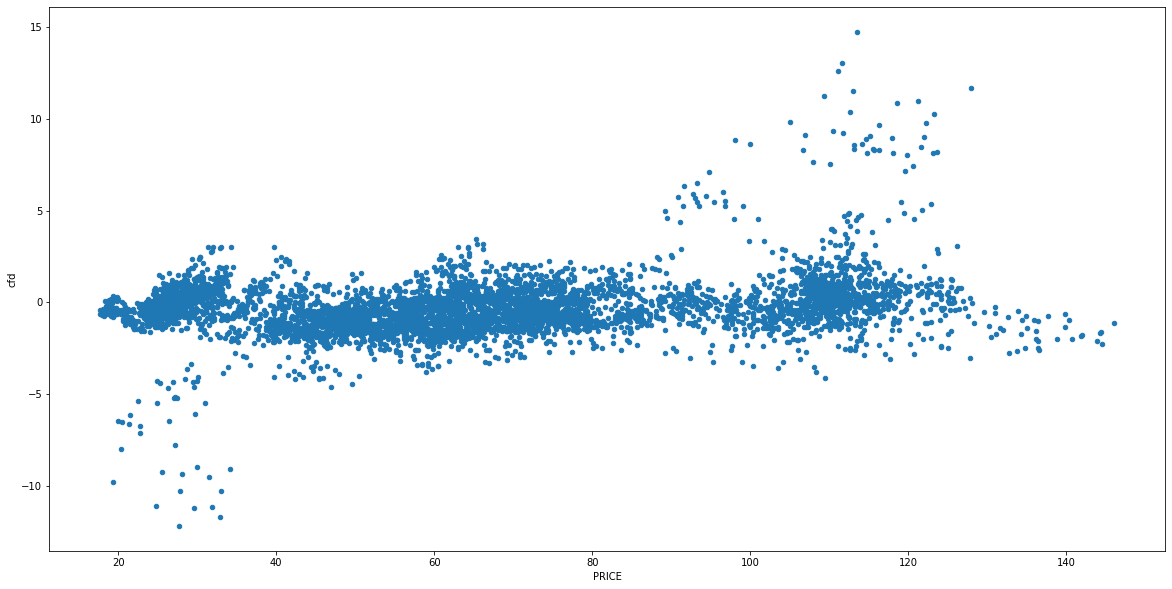

In [54]:
brent = cfd_corr(brent_M1)
brent.plot(kind='scatter',figsize=(20,10), x='PRICE', y='cfd')

<AxesSubplot:xlabel='PRICE', ylabel='cfd'>

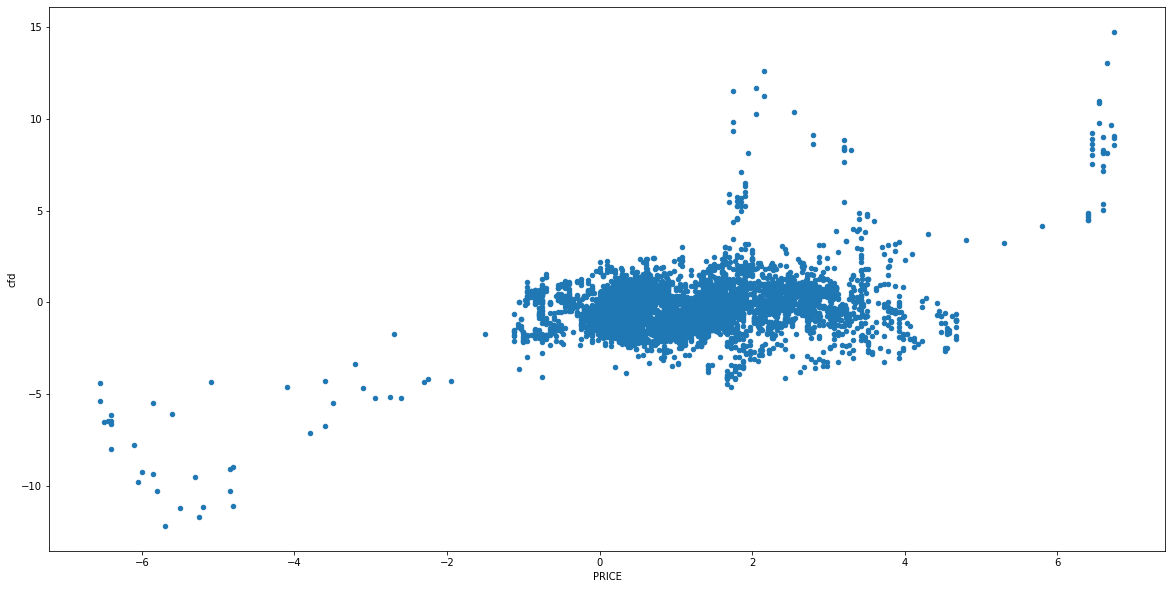

In [52]:
bonny = cfd_corr('model://PLATTS_RI/PLATTS.CRUDE.RI.AAGXL00/MID/ALL')
bonny.plot(kind='scatter',figsize=(20,10), x='PRICE', y='cfd')

In [28]:
eko[eko['cfd']<-10]

cfd  PRICE
2020-04-01 -11.10  -3.50
2020-04-06 -10.29  -3.55
2020-04-07 -11.17  -3.55
2020-04-08 -11.68  -3.55
2020-04-14 -11.22  -3.55
2020-04-15 -12.20  -3.60
2020-04-16 -10.26  -3.65

In [64]:
from datetime import datetime as dt

In [86]:
propane_asia = dg.get_curve('model://PI_OIL_PROD_LIG/PI.PROPANE.FOBSING.USD.BBL.C/CURVE/')

In [87]:
propane_asia[propane_asia['TENOR']=='M02']

TENOR                                             SOURCE      PRICE
2019-10-01   M02  M01-model://PVMCOBTSP/EU.RP.C3_NWE.SPRD.PVM.FW...  34.554129

In [94]:
murban_asia = dg.get_time_series('model://PLATTS_RP/PLATTS.CRUDE.RP.FWD.MURBAN_DUBAI.M01/CLOSE/ALL', from_date=dt(2018,1,1), to_date=dt(2022,7,1))

<AxesSubplot:>

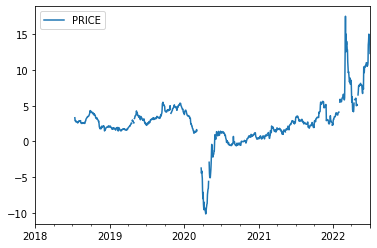

In [95]:
murban_asia.plot()

### series testing

In [9]:
lpg_model = 'model://PI_OIL_PROD_LIG/PI.PROPANE.CCIFNWE.USD.MT.C/CURVE/M01'
lpg = dg.get_time_series(lpg_model, datetime.date(2020,1,1), datetime.date(2021,10,1))

<AxesSubplot:>

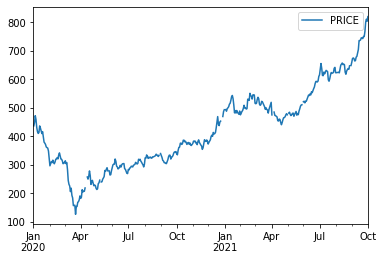

In [10]:
lpg.plot()